# Magistrates
* This notebook generates figures for the 'bail set by' page of the dashboard. 
* Note that some of these figures overlap with the magistrate section in 'dashboard.ipynb'

In [1]:
import ast
import datetime
import itertools
import matplotlib.pyplot as plt
from matplotlib import rc_file_defaults
from matplotlib import ticker

plt.style.use('ggplot')

import os
import sys
import numpy as np
import pandas as pd
import random
import regex as re
import seaborn as sns

from dateutil.relativedelta import relativedelta
from gensim.models.nmf import Nmf
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from scipy.stats import chi2_contingency, mannwhitneyu, wilcoxon
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from wordcloud import WordCloud

import plotly.express as px
import plotly.graph_objs as go
from ipywidgets import widgets
from plotly.subplots import make_subplots

import json
import copy

In [2]:
# Set various data and figure directories relative to cwd
# (which is hopefully always this file's dirname)
cwd = os.getcwd()
cwd_split = os.path.split(cwd)
srcdir = cwd_split[0]
#sys.path.append(os.path.abspath(os.path.join('..', cwd_split[-1])))
sys.path.append(srcdir)
root = os.path.split(srcdir)[0]
rawdir = os.path.join(root, "data/raw") # Raw csv files; local only!
tmpdir = os.path.join(root, "data/tmp") # Intermediate data products; local only!
extdir = os.path.join(root, "data/external") # Data from external sources; in repo
cleandir = os.path.join(root, "data/cleaned") # Data for dashboard generation; in repo
figdir = os.path.join(root, "figures") # Final figures; in repo

In [3]:
import pltformat
colorDict = pltformat.get_color_dictionary()

# Import and preprocess

In [4]:
import preprocess

In [5]:
# Set raw csv data file paths
docketcsv = "docket_reparse_03_02_2021.csv"
courtcsv = "court_summary.csv"
outcsv = "processed_data.csv"
trimmedcsv = "app_data.csv"

docketpath = os.path.join(rawdir, docketcsv)
courtpath = os.path.join(rawdir, courtcsv)
outpath = os.path.join(tmpdir, outcsv)
trimmedpath = os.path.join(cleandir, trimmedcsv)


In [6]:
docketdf = pd.read_csv(docketpath, index_col=0)

In [7]:
# Merge and clean docket and court summary data and save to new csv file
df = preprocess.merge_and_clean_data(docketpath, courtpath,
                                     outPath=outpath, verbose=True)

Removing 13 cases for which prelim_hearing_dt - bail_date was more than 5...
> Imported 24225 rows with 25 columns:
age
age_group
arrest_dt
arresting_officer
attorney
attorney_type
bail_amount
bail_date
bail_paid
bail_set_bin
bail_set_by
bail_type
case_status
dob
is_bail_posted
is_philly_zipcode
offense_date
offense_type
offenses
prelim_hearing_dt
prelim_hearing_time
race
sex
statute
zip
> Saved new file


In [8]:
df.head()

,attorney,attorney_type,offenses,offense_date,statute,offense_type,bail_set_by,bail_amount,bail_paid,bail_date,...,arrest_dt,prelim_hearing_dt,prelim_hearing_time,sex,race,is_philly_zipcode,age,age_group,bail_set_bin,is_bail_posted
0,Defender Association of Philadelphia,Public,"[DUI: Gen Imp/Inc of Driving Safely - 1st Off,...",2019-12-31,"[75 § 3802, 75 § 3323]",[driving after imbibing alcohol or utilizing d...,"Bernard, Francis X.",0.0,0.0,2020-01-01,...,2020-01-01,2020-01-01,2021-04-03 04:05:00,Male,White,1,25.0,18 to 25,None,0
1,Joseph Kevin Kelly,Private,[DUI: Gen Imp/Inc of Driving Safely - 1st Off],2019-12-31,[75 § 3802],[driving after imbibing alcohol or utilizing d...,"Bernard, Francis X.",0.0,0.0,2020-01-01,...,2020-01-01,2020-01-01,2021-04-03 04:07:00,Male,White,1,24.0,18 to 25,None,0
2,Defender Association of Philadelphia,Public,[Retail Theft-Take Mdse],2019-12-31,[18 § 3929],[theft and related offenses],"Bernard, Francis X.",0.0,0.0,2020-01-01,...,2019-12-31,2020-01-01,2021-04-03 04:10:00,Male,Black,1,57.0,26 to 64,None,0
3,Defender Association of Philadelphia,Public,"[Simple Assault, Recklessly Endangering Anothe...",2019-12-31,"[18 § 2701, 18 § 2705]","[assault, assault]","Bernard, Francis X.",30000.0,0.0,2020-01-01,...,2019-12-31,2020-01-01,2021-04-03 04:15:00,Male,Black,1,32.0,26 to 64,25k to 50k,0
4,Lee Mandell,Court Appointed,"[Robbery-Inflict Threat Imm Bod Inj, Conspirac...",2019-12-31,"[18 § 3701 §§ A1IV, 18 § 903 §§ C, 18 § 3921 §...","[robbery, inchoate crimes, theft and related o...",No Magistrate Found,30000.0,0.0,2020-01-01,...,2020-01-01,2020-01-01,2021-04-03 08:39:00,Male,Black,1,18.0,18 to 25,25k to 50k,0


# 1. Select magistrates

In [9]:
print('Total number of magistrates: ', len(df['bail_set_by'].value_counts()))

Total number of magistrates:  37


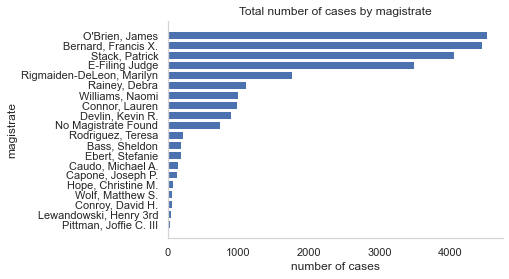

In [10]:
# number of cases handled by each magistrate
n_magistrates = 20
plt.barh(df['bail_set_by'].value_counts()[:n_magistrates].keys()[::-1], df['bail_set_by'].value_counts()[:n_magistrates].values[::-1])
plt.xlabel('number of cases')
plt.ylabel('magistrate')
plt.title('Total number of cases by magistrate')
plt.show()

In [12]:
# create dataframe summarizing magistrate-level information
df_magistrate = pd.crosstab(index = df['bail_set_by'], columns =df['bail_type'])
# note: total excludes any entries with 'bail_type' == NaN
df_magistrate['Total'] = df_magistrate.sum(axis = 1)
df_magistrate.sort_values(by = ['Total'], ascending = False, inplace = True)
print('Total number of magistrates (with valid bail type): {0}'.format(len(df_magistrate.index)))

# Magistrates that were involved in more than caseFloor cases
caseFloor = 500
magistrates = df_magistrate[df_magistrate['Total'] > caseFloor].index
print("Number of magistrates with more than {0} cases: {1}".format(caseFloor, len(magistrates)))

# print the selected magistrates
print("\nMagistrates who handled more than 500 cases in 2020")
for name in magistrates:
    print(name)

Total number of magistrates (with valid bail type): 37
Number of magistrates with more than 500 cases: 10

Magistrates who handled more than 500 cases in 2020
O'Brien, James
Bernard, Francis X.
Stack, Patrick
E-Filing Judge
Rigmaiden-DeLeon, Marilyn
Rainey, Debra
Williams, Naomi
Connor, Lauren
Devlin, Kevin R.
No Magistrate Found


In [13]:
# Select 'core_magistrates' to be those who handled more than 1000 cases in 2020
caseFloor = 1000
core_magistrates = df_magistrate[df_magistrate['Total'] > caseFloor].index
print("Number of magistrates with more than {0} cases: {1}".format(caseFloor, len(core_magistrates)))

# select core magistrates
print("\nSelected core magistrates: Magistrates who handled more than 1000 cases in 2020 ")
for name in core_magistrates:
    print(name)

Number of magistrates with more than 1000 cases: 6

Selected core magistrates: Magistrates who handled more than 1000 cases in 2020 
O'Brien, James
Bernard, Francis X.
Stack, Patrick
E-Filing Judge
Rigmaiden-DeLeon, Marilyn
Rainey, Debra


In [14]:
# create columns
df['core_magistrate'] = df['bail_set_by'].apply(lambda x: 1 if x in core_magistrates else 0)
df['magistrate'] = df['bail_set_by'].apply(lambda x: x if x in magistrates else 'Other')

In [15]:
# assign specific colors to each magistrate
magistrate_colors = dict({"Bernard, Francis X.": '#E84855',
    "Rigmaiden-DeLeon, Marilyn": '#17C3B2',
    "O'Brien, James": '#FE8589',
    "Stack, Patrick": '#FFCB77',
    "E-Filing Judge": '#19647E',
    "Rainey, Debra": '#FA9E3B',
    "Connor, Lauren": '#227C9D',
    "Williams, Naomi": '#9BD3A6',
    "Devlin, Kevin R.": '#415865',
    "No Magistrate Found": '#fec5bb', 
    "Other": '#2E4756'})

# 2. 2020 year-end summary by magistrate 
* For year-end summary, report for the 9 selected magistrates (who handled more than 500 cases) and all others (under category 'Other')

In [16]:
# remove "No magistrate found" from list of magistrates
magistrates = list(magistrates)

In [17]:
# reorder magistrates list
"""
magistrates_list = ['Connor, Lauren',
                    'Bernard, Francis X.', 
                    'Rigmaiden-DeLeon, Marilyn',
                    'Rainey, Debra',
                    "O'Brien, James",
                    'Stack, Patrick',
                    'E-Filing Judge',
                    'Williams, Naomi',
                    'Devlin, Kevin R.',
                    'Other']
"""

'\nmagistrates_list = [\'Connor, Lauren\',\n                    \'Bernard, Francis X.\', \n                    \'Rigmaiden-DeLeon, Marilyn\',\n                    \'Rainey, Debra\',\n                    "O\'Brien, James",\n                    \'Stack, Patrick\',\n                    \'E-Filing Judge\',\n                    \'Williams, Naomi\',\n                    \'Devlin, Kevin R.\',\n                    \'Other\']\n'

In [20]:
df_magistrate = pd.crosstab(index = df['magistrate'], columns =df['bail_type'])
# note: total excludes any entries with 'bail_type' == NaN
df_magistrate['Total'] = df_magistrate.sum(axis = 1)
df_magistrate.sort_values(by = ['Total'], ascending = False, inplace = True)

# get total bail amount set
df_amount = df[['magistrate','bail_amount']].groupby(by = ['magistrate']).sum()

# merge the two 
df_magistrate = pd.concat([df_magistrate.stack(), df_amount.stack()[magistrates]], axis = 0).unstack()

In [21]:
# convert bail type count to percentage
df_magistrate[["Monetary_count", "Nonmonetary_count", "Denied_count", "ROR_count", "Unsecured_count"]] = df_magistrate[['Monetary', 'Nonmonetary', 'Denied', 'ROR','Unsecured']]
df_magistrate[['Monetary', 'Nonmonetary', 'Denied', 'ROR','Unsecured']] = df_magistrate[['Monetary', 'Nonmonetary', 'Denied', 'ROR','Unsecured']].apply(lambda x: x* 100/ df_magistrate['Total'])

# combine 'nonmonetary' and 'denied'
df_magistrate['Other'] = df_magistrate['Nonmonetary'] + df_magistrate['Denied']
df_magistrate["Other_count"] = df_magistrate["Nonmonetary_count"] + df_magistrate["Denied_count"]
df_magistrate.drop(columns = ['Nonmonetary', 'Denied', "Nonmonetary_count","Denied_count"], inplace = True)

# change column formats
df_magistrate[["Monetary", "ROR","Unsecured", "Other"]] = df_magistrate[["Monetary", "ROR","Unsecured", "Other"]].apply(lambda x: round(x,2))
df_magistrate[["Monetary_count", "ROR_count", "Unsecured_count", "Other_count", "Total"]] = df_magistrate[["Monetary_count", "ROR_count", "Unsecured_count", "Other_count", "Total"]].astype(int)

# format bail amount
df_magistrate["bail_amount"] = df_magistrate["bail_amount"].apply(lambda x: "${:,.0f}".format(x/1000))

# keep last names of magistrates
df_magistrate.rename(index = lambda x: x.split(',')[0] if x != "No Magistrate Found" else x, inplace = True)

df_magistrate.sort_values(by = ['Total'], ascending = True, inplace = True)


In [22]:
#save data
magistrate_path = os.path.join(cleandir, "app_magistrate_data.csv")
#df_magistrate.to_csv(magistrate_path)

In [26]:
df_magistrate = pd.read_csv(magistrate_path)

In [43]:
bail_type = ["Monetary", "ROR", "Unsecured", "Other"]
x_data = np.array(df_magistrate[bail_type])
x_t = x_data.transpose()

x_hover = np.array(df_magistrate[["Monetary_count", "ROR_count", "Unsecured_count", "Other_count"]])
x_ht = x_hover.transpose()

y_data = list(df_magistrate['magistrate'].values)

total_count = df_magistrate['Total'].astype(int)
bail_set = df_magistrate["bail_amount"]

In [47]:
# plot interactive bar plot
fig = go.Figure()

for i in range(4):
    
    # text
    text = [str(item)+"%"  if item > 5 else "" for item in x_t[i]]
    
    # hover text
    # include monetary bail
    if i == 0: 
        hovertext = ["name: " + name + "<br>"
                 + "percentage: " + str(perct) + "%" + "<br>"
                 + "case count: " + str(case) + " / " + str(total) + "<br>"
                 + "total monetary bail amount set: " + str(amount) 
                 for name, perct, case, total, amount in zip(y_data, x_t[i], x_ht[i], total_count, bail_set)]
    else:
        hovertext = ["name: " + name + "<br>"
                 + "percentage: " + str(perct) + "%" + "<br>"
                 + "case count: " + str(case) + " / " + str(total)
                 for name, perct, case, total in zip(y_data, x_t[i], x_ht[i], total_count)]
        
    fig.add_trace(go.Bar(
        y = y_data,
        x = x_t[i],
        text = text,
        textposition = "inside",
        name = bail_type[i],
        hoverinfo = 'text',
        hovertext = hovertext,
        orientation = 'h'))
    
fig.update_layout(barmode='stack',
                 legend = {'traceorder': 'normal'},
                 xaxis_title="percentage",
                 yaxis_title="magistrate",
                 legend_title="bail type",
                 
                 
                 )
fig.show()

In [25]:
f2 = go.FigureWidget(fig)
f2

FigureWidget({
    'data': [{'hoverinfo': 'text',
              'hovertext': [name: No Magistrate Found<br>per…

<b> To do </b>
* Colors of the bars?
* The hovering right now makes it look like the count is for cases of the specific bail type... May want to make this clearer.

In [ ]:
# year-end summary for 2021
# using dropdown

In [40]:
# for 2021 data

In [ ]:
# the dockets parsed only has bail set until 01/01/2021